### Heat equation
Physics form:
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} = \nu \frac{\partial^2 u(t,x)}{\partial x^2}$$
$u(t,x)$: velocity of fluid, $\nu$: viscosity of fluid <br><br>

General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$<br>

In Maziar Raissi, Paris Perdikaris, and George Em Karniadakis paper: <br>
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} -\frac{0.01}{\pi} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$ <br>
$$u(0,x) = -sin(\pi x) \textrm{, which is the initial condition}$$ <br>
$$u(t,-1) = u(t,1) = 0 \textrm{, which is the Dirichlet boundary conditions}$$<br>
$$x \in [-1,1], \textrm{ }t\in [0,1]$$
Close to the exact solution is $u(t,x) = e^{-t}sin(\pi x)$, [here is the exact analytical solution.](https://www.sciencedirect.com/science/article/abs/pii/0045793086900368)

### lol no that's the wrong equation :)

In [79]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

### DNN

In [80]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    

### PINN

In [81]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, x, t, a, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"x shape: {x.shape}")
            print(f"t shape: {t.shape}")
            print(f"a shape: {a.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        
        # generate collocation points (first N_col points from the randomly sampled vectors)
        N_col = 10
        xcol = x[:N_col,:,:]
        tcol = t[:,:N_col,:]
        acol = a[:,:,:N_col]
        x_inter, t_inter, a_inter = np.meshgrid(xcol, tcol, acol)
        grid_col = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.col_x_tensor = torch.tensor([grid_col[:,0]], requires_grad=True).T.float().to(self.device)
        self.col_t_tensor = torch.tensor([grid_col[:,1]], requires_grad=True).T.float().to(self.device)
        self.col_a_tensor = torch.tensor([grid_col[:,2]], requires_grad=False).T.float().to(self.device)

        
        # generate support points (last N_sup points from the randomly sampled vectors)
        N_sup = 8    # number of support points
        xsup = x[-N_sup:,:,:]
        tsup = t[:,-N_sup:,:]
        asup = a[:,:,-N_sup:]
        x_inter, t_inter, a_inter = np.meshgrid(xsup, tsup, asup)
        grid_sup = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.sup_x_tensor = torch.tensor([grid_sup[:,0]], requires_grad=True).T.float().to(self.device)
        self.sup_t_tensor = torch.tensor([grid_sup[:,1]], requires_grad=True).T.float().to(self.device)
        self.sup_a_tensor = torch.tensor([grid_sup[:,2]], requires_grad=False).T.float().to(self.device)
        
        
        
        # generate grids for boundary conditions:

        # 1. x=0 and x=pi boundary points
        # initial condition points(x=0)
        x_inter, t_inter, a_inter = np.meshgrid(0, t, a)
        x0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.x0_x_tensor = torch.tensor([x0_grid[:,0]], requires_grad=True).T.float().to(self.device)
        self.x0_t_tensor = torch.tensor([x0_grid[:,1]], requires_grad=True).T.float().to(self.device)
        self.x0_a_tensor = torch.tensor([x0_grid[:,2]], requires_grad=False).T.float().to(self.device)

        
        # final condition points (x=pi)
        x_inter, t_inter, a_inter = np.meshgrid(math.pi, t, a)
        xpi_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.xpi_x_tensor = torch.tensor([xpi_grid[:,0]], requires_grad=True).T.float().to(self.device)
        self.xpi_t_tensor = torch.tensor([xpi_grid[:,1]], requires_grad=True).T.float().to(self.device)
        self.xpi_a_tensor = torch.tensor([xpi_grid[:,2]], requires_grad=False).T.float().to(self.device)


        
        # 2. t=0 initial condition points
        x_inter, t_inter, a_inter = np.meshgrid(x, 0, a)
        t0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.t0_x_tensor = torch.tensor([t0_grid[:,0]], requires_grad=True).T.float().to(self.device)
        self.t0_t_tensor = torch.tensor([t0_grid[:,1]], requires_grad=True).T.float().to(self.device)
        self.t0_a_tensor = torch.tensor([t0_grid[:,2]], requires_grad=False).T.float().to(self.device)


        '''
        # 3. a=0 and a=1 boundary points
        # initial condition points(a=0)
        x_inter, t_inter, a_inter = np.meshgrid(x, t, 0)
        a0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 

        self.a0_x_tensor = torch.tensor([a0_grid[:,0]], requires_grad=True).T.float().to(self.device)
        self.a0_t_tensor = torch.tensor([a0_grid[:,1]], requires_grad=True).T.float().to(self.device)
        self.a0_a_tensor = torch.tensor([a0_grid[:,2]], requires_grad=False).T.float().to(self.device)

        # final condition points(a=1)
        x_inter, t_inter, a_inter = np.meshgrid(x, t, 1)
        a1_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None]))
        
        self.a1_x_tensor = torch.tensor([a1_grid[:,0]], requires_grad=True).T.float().to(self.device)
        self.a1_t_tensor = torch.tensor([a1_grid[:,1]], requires_grad=True).T.float().to(self.device)
        self.a1_a_tensor = torch.tensor([a1_grid[:,2]], requires_grad=False).T.float().to(self.device)
        '''
        

        # adam optimizer
        self.max_iter = 4000
        self.optimizer = torch.optim.Adam(self.net.parameters())

        
        self.iter = 0
    
    '''
    # exact solution
    def f_exact(self, x, t, a):
        return 2*np.sin(2*x)*np.exp(-(a**2)*t)
    '''
    def net_u(self, x, t, a): #get u(x,t, a) for a pair (x,t, a); a forward pass through the PINN
        u = self.net(torch.cat([x, t, a], dim=1))
        return u
    
    def net_f(self, x, t, a): #get f = u_t + u * u_x - self.nu * u_xx; the true u(x,t) makes f = 0
        u = self.net_u(x, t, a)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t - (a**2)*u_xx   #the computed PDE, we want to be a close as possible to 0
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        # x=0 and x=pi boundary points
        u_pred_x0 = self.net_u(self.x0_x_tensor, self.x0_t_tensor, self.x0_a_tensor) # all the ic/bc pairs were fed through the PINN
        u_pred_xpi = self.net_u(self.xpi_x_tensor, self.xpi_t_tensor, self.xpi_a_tensor)
        
        # t=0 boundary points
        u_pred_t0 = self.net_u(self.t0_x_tensor, self.t0_t_tensor, self.t0_a_tensor)
        
        # evalutation of main equation using collocation points
        f_pred = self.net_f(self.col_x_tensor, self.col_t_tensor, self.col_a_tensor) # all the collocations points were fed through the PINN

        '''
        # a=0 and a=1 boundary points
        u_pred_a0 = self.net_u(self.a0_x_tensor, self.a0_t_tensor, self.a0_a_tensor) # all the ic/bc pairs were fed through the PINN
        u_pred_a1 = self.net_u(self.a1_x_tensor, self.a1_t_tensor, self.a1_a_tensor)
        '''

        
        # predictions over support points
        u_pred_sup = self.net_u(self.sup_x_tensor, self.sup_t_tensor, self.sup_a_tensor)
        

        #ic/bc on x
        loss_u = torch.mean(u_pred_x0 ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_u += torch.mean(u_pred_xpi ** 2)
        # ic on t
        loss_u += torch.mean((2*torch.sin(2*self.t0_x_tensor) - u_pred_t0) ** 2)
        '''
        #ic/bc on a
        loss_u += torch.mean((2*torch.sin(2*self.a0_x_tensor) - u_pred_a0) ** 2)
        loss_u += torch.mean((2*torch.sin(2*self.a1_x_tensor)*torch.exp(-self.a1_t_tensor) - u_pred_a1) ** 2)
        '''

        # main equation loss
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term

        
        # loss of support points against true solution
        loss_sup = torch.mean((2*torch.sin(2*self.sup_x_tensor)*torch.exp(-(self.sup_a_tensor*self.sup_a_tensor)*self.sup_t_tensor) - u_pred_sup) ** 2)
        

        loss = loss_u + loss_f + loss_sup #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
        
        for i in range(self.max_iter):
            # Backward and optimize
            self.optimizer.step(self.loss_func)

            
    def predict(self, xta):
        x = torch.tensor([xta[:, 0]], requires_grad=True).T.float().to(self.device) #get x from pair
        t = torch.tensor([xta[:, 1]], requires_grad=True).T.float().to(self.device) #get t from pair
        a = torch.tensor([xta[:, 2]], requires_grad=False).T.float().to(self.device) #get t from pair

        self.net.eval()

        u = self.net_u(x, t, a) 
        f = self.net_f(x, t, a)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data generation

In [82]:
x_true = math.pi*np.linspace(0,1,90)
t_true = np.linspace(0,1,90)
a_true = np.linspace(0,1,90)
# exact solution
def f_exact(x,t,a):
    return 2*np.sin(2*x)*np.exp(-(a**2)*t)

x_inter, t_inter, a_inter = np.meshgrid(x_true, t_true, a_true)
grid_exact = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
ex = f_exact(grid_exact[:,0], grid_exact[:,1], grid_exact[:,2]).reshape(-1,1)

### Create and train

In [83]:
nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([3]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

# Number of points in each dimensions
N_x = 80
N_t = 80
N_a = 80
# generate grid for collocation and boundary points
x = math.pi * np.random.rand(N_x,1,1)
t = np.random.rand(1,N_t,1)
a = np.random.rand(1,1,N_a)

#model = PINN(layers, lambda_1, lambda_2, xt_train, xt_f, u_train)
model = PINN(layers, x, t, a, tol=1e-5, hs=50)

model.train()

device used: cuda:0
x shape: (80, 1, 1)
t shape: (1, 80, 1)
a shape: (1, 1, 80)
Iter 100, Loss: 2.22530e-01, Loss_u: 1.01085e-01, Loss_f: 8.69922e-02
Iter 200, Loss: 1.20098e-01, Loss_u: 5.87652e-02, Loss_f: 4.13136e-02
Iter 300, Loss: 9.81013e-02, Loss_u: 5.08545e-02, Loss_f: 2.88119e-02
Iter 400, Loss: 9.46023e-02, Loss_u: 4.51537e-02, Loss_f: 2.41731e-02
Iter 500, Loss: 7.14641e-02, Loss_u: 3.27799e-02, Loss_f: 1.96235e-02
Iter 600, Loss: 6.86278e-02, Loss_u: 2.77925e-02, Loss_f: 1.81622e-02
Iter 700, Loss: 5.61317e-02, Loss_u: 2.62757e-02, Loss_f: 1.36883e-02
Iter 800, Loss: 4.82965e-02, Loss_u: 1.80115e-02, Loss_f: 1.29912e-02
Iter 900, Loss: 4.43321e-02, Loss_u: 1.55044e-02, Loss_f: 1.18152e-02
Iter 1000, Loss: 9.17317e-02, Loss_u: 6.02441e-02, Loss_f: 1.02015e-02
Iter 1100, Loss: 3.81783e-02, Loss_u: 1.18294e-02, Loss_f: 9.93526e-03
Iter 1200, Loss: 3.55970e-02, Loss_u: 1.06697e-02, Loss_f: 9.05662e-03
Iter 1300, Loss: 3.33997e-02, Loss_u: 9.61969e-03, Loss_f: 8.23382e-03
Iter 1

### Evaluate

In [84]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred, f_pred = model.predict(grid_exact)

l2_u = l2_norm(u_pred, ex)  #u_sol 25600,1 contains the exact solution
print('L2 Error u: %e' % (l2_norm(u_pred, ex))) 

mse_u = mse(u_pred, ex)
mse_f = mse(f_pred, np.zeros(f_pred.shape))

print(f"MSE Error u: {mse_u}") 
print(f"MSE Error f: {mse_f}") 

L2 Error u: 1.675919e-01
MSE Error u: 0.04242999899891622
MSE Error f: 1.7887906327442842


### Plot

In [85]:
# 9 evalutations of f_exact for different fixed values of a and t:
true_lst = [] # list of 9 evaluations of f_exact
pred_lst = [] # list of 9 evaluations of PINN
x_true = x_true.reshape(1,-1).T   # evaluate f over fine grid of x_true (90,1)
x_len = x_true.shape[0]
a_lst = [0.25,0.5,0.75]
t_lst = [0.25,0.5,0.75]
for t in t_lst:
  for a in a_lst:
    t_vec = t*np.ones((x_len, 1)) #(90,1)
    a_vec = a*np.ones((x_len, 1)) #(90,1)
    # evaluate using exaxt solution
    true_lst.append(f_exact(x_true,t_vec,a_vec)) #(90,1)

    # evaluate same points using PINN
    grid_forNN = np.hstack((x_true.flatten()[:,None], t_vec.flatten()[:,None], a_vec.flatten()[:,None]))
    u_pred, _ = model.predict(grid_forNN)
    pred_lst.append(u_pred)

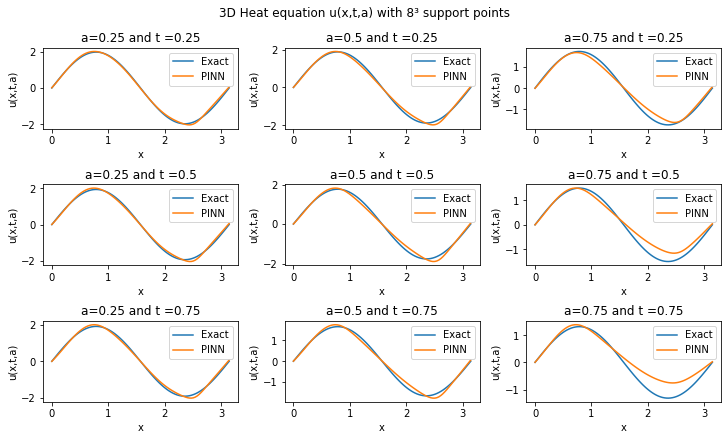

In [87]:
#to_plot=u_pred.reshape((90,90,90))
#true_plot= ex.reshape((90,90,90))
fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=False, constrained_layout = True)
for i in range(3):    #iterate over t
    for j in range(3):    #iterate over a
        axs[i,j].set_title(f'a={0.25*(j+1)} and t ={0.25*(i+1)}')
        axs[i,j].plot(x_true, true_lst[3*i+j])
        axs[i,j].plot(x_true, pred_lst[3*i+j])
        axs[i,j].legend(['Exact', 'PINN'])
        axs[i,j].set_xlabel('x')
        axs[i,j].set_ylabel('u(x,t,a)')
plt.suptitle('3D Heat equation u(x,t,a) with 8\u00b3 support points')
fig.show;
plt.savefig(fname='3D Heat equation u(x,t,a) with 8^3 support points')